# Standard Setup

### Imports 

In [6]:
# Standard things
import math
import numpy as np
import jax.numpy as jnp
import jax

# FLOAT64 seems to be necessary for integral precision
jax.config.update("jax_enable_x64", True)

# Project-specific things
# from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
# from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs
# from utils.distribution_utils import construct_pdf, construct_cdf

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers
from utils.distribution_utils import q

from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


### Jax setting and compilation

In [7]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

# Problem Setup

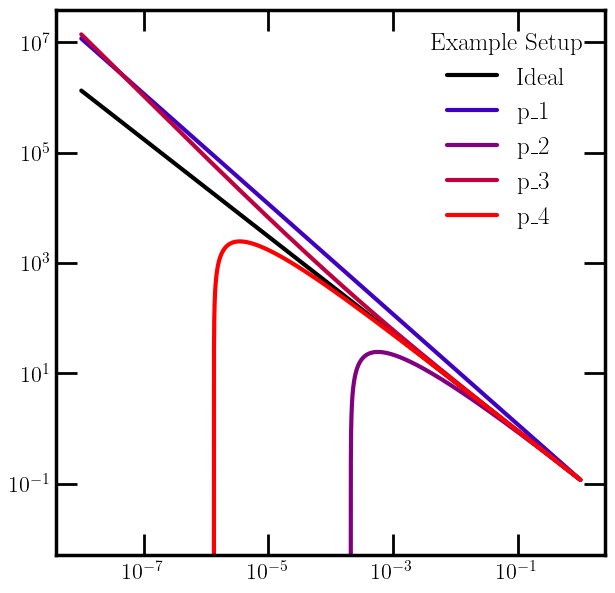

In [8]:
max_order = 5
num_trials = 50
extra_orders = 1





# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)



def exponential_distribution(t, alpha, params):
    return alpha  * jnp.exp(-alpha * t)


def p_order_N(t, alpha, M):

    result = jnp.zeros_like(t)
    for i in range(M ):
        result += alpha * jnp.power(-1 * alpha * t , i) / math.factorial(i)
    return result


# Colormap setup
colors = [0]
for order in range(1,max_order):

    o = (order) / (max_order-1)
    colors.append((o, 0, 1 - o))


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, exponential_distribution(t_from_x(xs) , 0.118, None) / xs, label="Ideal", color = "black")
for order in range(1,max_order):
    ax.plot(xs, p_order_N(t_from_x(xs), 0.118, order) / xs, label=f"p_{order}", color = colors[order])

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





### Alternate Problem: Angularity-like

In [9]:
# def exponential_distribution(t, alpha, params):

#     scale = 91.1876 * x_from_t(t)
#     L = jnp.log(scale / mz)
#     alpha_bar = running_coupling(alpha, mz, scale)

#     alpha_bar = alpha_bar * 4/3 / jnp.pi

#     beta_0 = (11 * 3 - 2 * 5) / (12 * jnp.pi)

#     integral = jnp.log( 1 - 2 * alpha_bar * jnp.pi / 4 * 3 * beta_0 * L) / (2 * beta_0)


#     return alpha_bar * t * jnp.exp(-integral) 


# def p_order_N(t, alpha, M):

#     scale = 91.1876 * x_from_t(t)
#     alpha_bar = running_coupling(alpha, mz, scale)


#     result = 0
#     alpha_bar = alpha_bar * 4/3 / jnp.pi
#     for i in range(M + 1):
#         result += alpha_bar * t * jnp.power(-1 * alpha_bar * t **2 / 2, i) / math.factorial(i)
#     return result

# Matching

In [10]:
t = jnp.linspace(0, 10, 1000)
xs = x_from_t(t)



# Array to save curves for plotting
data = np.zeros((max_order, t.shape[0], num_trials))

for order in range(1, max_order):


    m_order = order
    n_order = 1 * order

    # Normalization array, size includes extra orders
    factorials = np.zeros((m_order + 1 + extra_orders, n_order + 1 + extra_orders))
    for i in range(factorials.shape[0]):
        for j in range(factorials.shape[1]):
            factorials[i, j] = (i+1) # math.factorial(i) #* math.factorial(j)


    # Actually perform the matching
    print("Order: ", order)
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, m_order, n_order)


    for trial in range(num_trials):


        # Get a random seed
        seed = jax.random.PRNGKey(trial * 1000 + order * 100) 

        # print(g_mn_matched)
        # print(g_star)
    
        # Prior on the g_mn
        std = 10 / factorials
        g_mn = (2 * (jax.random.uniform(seed, factorials.shape))-1)   * std# - (std / 2)
        max_m = g_mn.shape[0]
        max_n = g_mn.shape[1]


        # set the highest order term to be negative
        g_mn = g_mn.at[order+1:max_m, max_n-1].set(-jnp.abs(g_mn[order+1:max_m, max_n-1]))

        # Set the coefficients of the random array to be the matched ones
        g_mn = g_mn.at[:m_order+1, :].set(0)
        g_mn = g_mn.at[:m_order+1, :n_order+1].set(g_mn_matched)


        # Save the curve
        data[order, :, trial] = jnp.nan_to_num(vmapped_q(t, 0.118, g_star, g_mn))



Order:  1
Order:  2
Order:  3
Order:  4


### Plots

Order 1
0.8315889430507099
0.9315300316645947
0.5521587634866743
0.4886841014805477
0.5972969171559712
0.46270262553490293
0.9369733931195033
0.5622719420994056
0.9544830445927831
0.6981808663805004
0.7417363080743832
0.9494542934989689
0.9406672433763974
0.7867037445505792
0.5298691276613414
0.9578003146923527
0.9324422984569283
0.5896855487302957
0.915966590736046
0.9918520703496244
0.9660955031499996
0.4665932146910205
0.6133659803479616
0.6169085841068109
0.9971184930045558
0.8421511687381502
0.47507350335219073
0.8336507177858631
0.8197156350090427
0.8120459828809636
0.8332652557430835
0.5490646018788279
0.9609439132808834
0.8452921235460422
0.9879394845793578
0.6694684339409394
0.8070887758478448
0.7161112783031677
0.6808303288976304
0.6664336815506817
0.5390187767148038
0.9183499215184151
0.7715765274646116
0.9059977349011932
0.7198582242768603
0.6561327286588436
0.9324146865519352
0.924079922825722
0.6047984276064112
0.7957650017221822
Order 2
0.8761768882882502
0.9225909151631

(0.9090909090909091, 1.1)

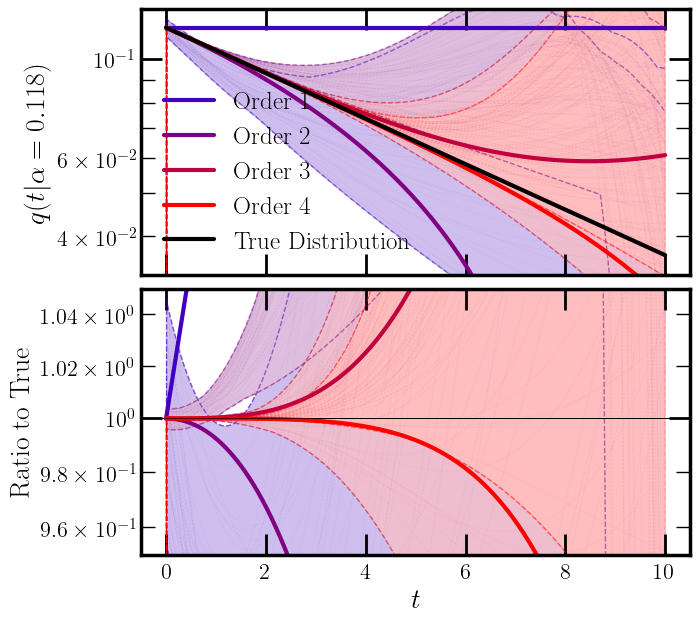

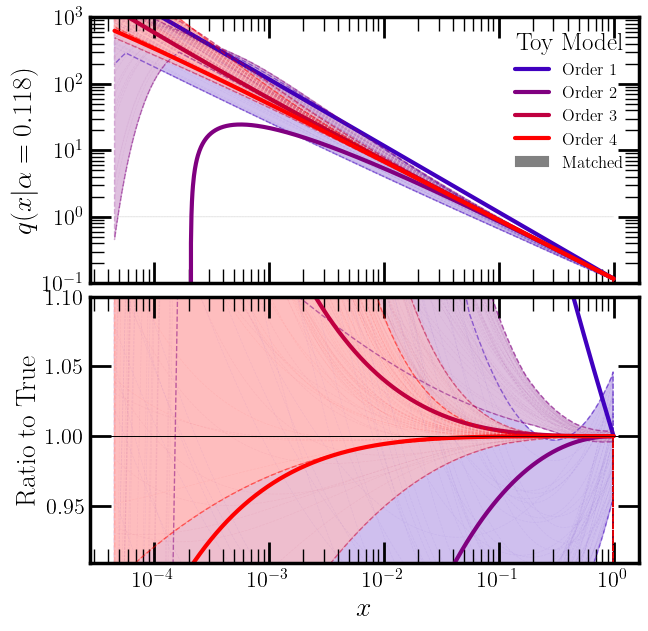

In [11]:
fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)




for order in range(1, max_order):
    ax[0].plot(t, p_order_N(t, 0.118, order), label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(t, data[order, :,trial], color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)



    mean = np.nanmean(data[order], axis = 1)
    # std = np.nanstd(data[order], axis = 1)
    plus = np.nanmax(data[order], axis = 1)
    minus = np.nanmin(data[order], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(t, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(t, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(t, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(t, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(t, (minus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(t, (plus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

    ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


ax[0].legend(loc = "lower left")

ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[1].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$q(t|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

max_y = 1.1 * np.max(exponential_distribution(t[1:], 0.118, None))
min_y = 0.9 * np.min(exponential_distribution(t[1:], 0.118, None))
ax[0].set_ylim(min_y, max_y)
ax[1].set_ylim(0.95, 1.05)






# ######################### X version #########################

fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)

xs = x_from_t(t)


# set ax[0] to take up the whole space

for order in range(1, max_order):

    print("Order" , order)

    ax[0].plot(xs, p_order_N(t, 0.118, order) / xs, label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(xs, data[order, :,trial] / xs , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(xs, data[order, :,trial] / exponential_distribution(t, 0.118, None) , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        integral = jnp.trapz(data[order, :,trial], t)
        # print(data[order, :,trial])
        print(integral)



    mean = np.nanmean(data[order], axis = 1) / xs
    plus = np.nanmax(data[order], axis = 1) / xs
    minus = np.nanmin(data[order], axis = 1) / xs


    std = np.nanstd(data[order], axis = 1) / xs

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(xs, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(xs, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(xs, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(xs, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None) * xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], alpha = 0.25, ls = "--")


    ax[1].plot(xs, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

# ax[0].plot(xs, exponential_distribution(t, 0.118, None)/ xs, label="True", color = "Black")

# Add shaded to legend
ax[0].fill_between(xs, np.ones_like(xs), np.ones_like(xs), color = "grey", alpha = 0.99, ls = "--", label = "Matched", lw = 0.1)


ax[0].legend(loc = "upper right", fontsize = 12, title = "Toy Model")

ax[0].set_yscale("log")
# ax[1].set_yscale("log")
ax[0].set_xscale("log")

ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$q(x|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1/1.1, 1.1)

# fig.delaxes(ax[1])
# # set ax[0] height 
# fig.set_figheight(12)

# Parameter Extraction

### Define the Dataset

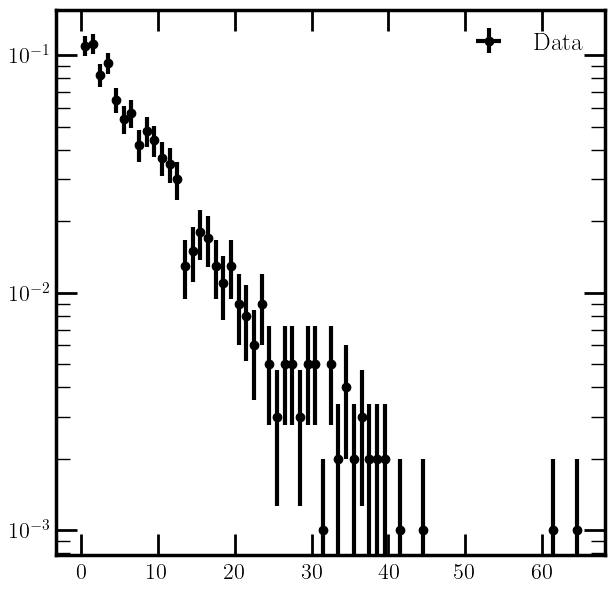

In [12]:
N_data = 1000
alpha_true = 0.118

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true

fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.legend()

plt.yscale("log")

### Attempt MLE with the Fixed Order

Text(0, 0.5, '$-2 \\log L(\\alpha)$')

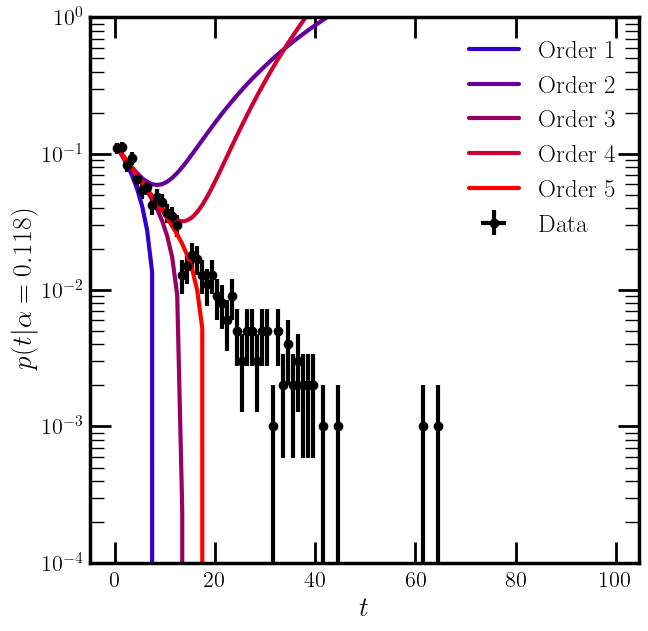

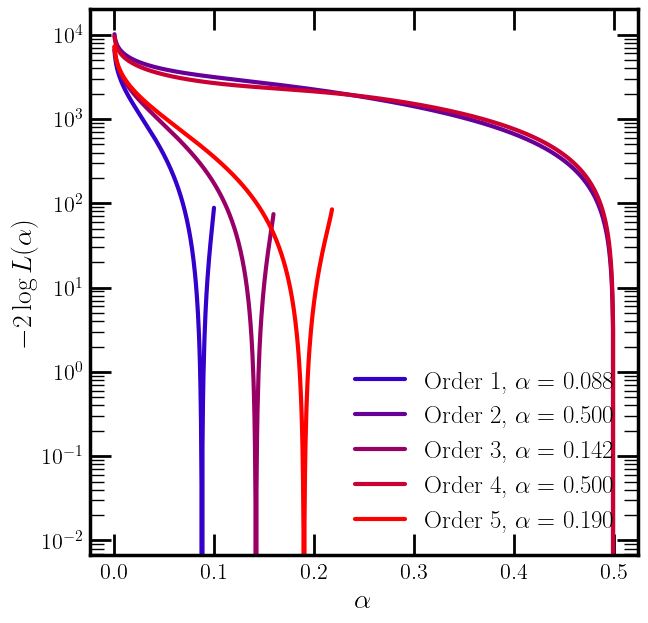

In [ ]:
# Get lambda functions for FO likelihoods




max_M = 5


fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")

plt.xlabel(r"$t$")
plt.ylabel(r"$p(t|\alpha = 0.118)$")

plt.ylim(1e-4, 1e0)

plt.legend()


fig, ax = newplot("full")                                                                       
for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted[t_sorted < 10]


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}, " + r"$\alpha = $" +  f"{best_alpha : .3f}", color = color)

plt.legend()
plt.yscale("log")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-2 \log L(\alpha)$")


(2, 2)
(3, 3)


NameError: name 'log_q' is not defined

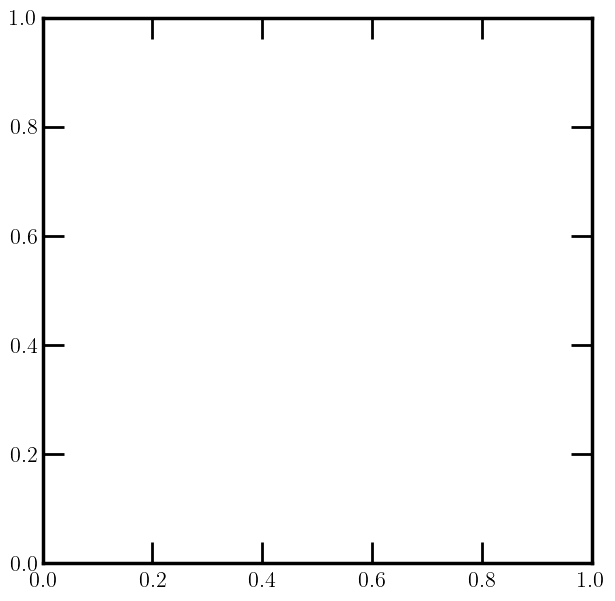

In [ ]:
from scipy.optimize import minimize
from tqdm import tqdm

# Only 1 higher order term works for now
num_higher_orders = 1

# highest order to try
max_M = 1

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):


    # Initialize g_mn by matching the low order stuff
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)

    # Data cutoff
    masked_data = t_data[t_data < 25]

    # Likelihood function, params[0] = alpha, params[1:] = higher order g_mn
    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        # Set g so that the lower order terms are matched and the higher order terms are the ones we are varying
        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(vmapped_q(masked_data, alpha, g_star, g_mn)))
    
    # Profile likelihood whe alpha is a parameter and g_mn_higher is varied
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):


        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(vmapped_q(masked_data, alpha, g_star, g_mn)))
    

    ###### Minimize likelihood function #####
    # This is the denominator of the profile likelihood ratio

    # Initial guess: alpha = 0.118, g_mn = 0
    initial_alpha = 0.118
    initial_guess = jnp.zeros(g_mn.shape[1]+1)
    initial_guess = initial_guess.at[0].set(initial_alpha)

    # Minimize the full likelihood to et the best alpha and g_mn
    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    print("Order", i)
    print("Full Min", res_full.fun)
    print("Full Alpha", res_full.x[0])
    print("Full Coeffs", res_full.x[1:])


    ###### Minimize profile likelihood function #####

    # Scan over alpha
    alphas = jnp.linspace(0.10, 0.15, 50)

    # Minimize for each alpha, using the g_mn from the full minimization as a starting point
    def profile_minimize(alphas):
        res_partial = minimize(profile_likelihood_function, res_full.x[1:], args=(alphas), method='Nelder-Mead', options={'disp': False})
        return res_partial.fun

    likelihoods = jnp.zeros(alphas.shape)
    for j, alpha in tqdm(enumerate(alphas)):
        res_partial = profile_minimize(alpha)
        likelihoods = likelihoods.at[j].set(res_partial)

    # Subtract the minimum of the full likelihood. Should now have a min of zero
    likelihoods = likelihoods - res_full.fun


    # Plot
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = colors[i])


    # Try to get the +- likelihood band
    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]



    # minus_one = alphas_less_than_one[0]
    # plus_one = alphas_less_than_one[-2]

    # Vertical band
    # ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])

    print("Order", i)
    print("Min Alpha", min_alpha)
    # print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

plt.yscale("log")

# Test Debugging


(2, 2)
(3, 3)
Order 1
Full Min 5896.162145621315
Full Alpha 0.15628981990963753
Full Coeffs [-0.28050445  0.09965496 -0.33081924]
Likelihood 7197.193168541819
(3, 3)
(4, 4)
Order 2
Full Min 5795.750410035484
Full Alpha 0.1023901943874988
Full Coeffs [ 0.00307076 -0.18117998  0.06008596  0.1475639 ]
Likelihood inf
(4, 4)
(5, 5)
Order 3
Full Min 5750.298106845591
Full Alpha 0.13156409873381214
Full Coeffs [-0.07570901  1.6542554  -0.9786358  -1.05979033 -0.01371186]
Likelihood 7634.947315571612
(5, 5)
(6, 6)
Order 4
Full Min 5765.406602948021
Full Alpha 0.11920449228531785
Full Coeffs [-0.00464118  0.0081913   0.00460497  0.00327757 -0.01431362  0.01030467]
Likelihood inf


(0.0001, 1.0)

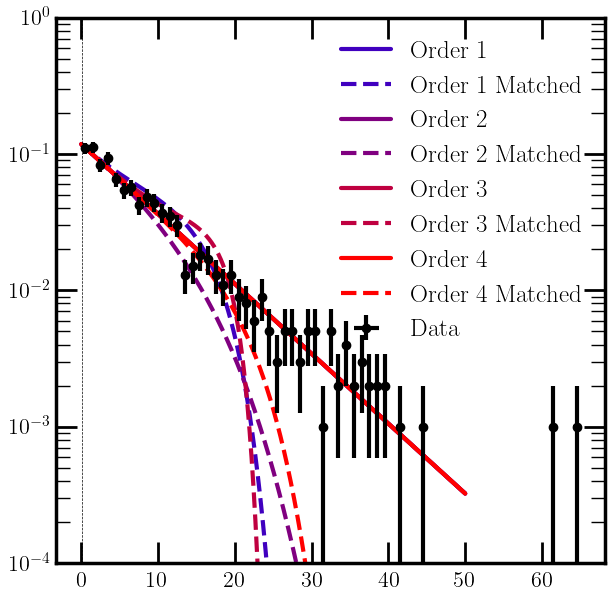

In [ ]:
from scipy.optimize import minimize
from tqdm import tqdm


num_higher_orders = 1

max_M = 4

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))


    print(g_mn_matched.shape)
    print(g_mn.shape)
    # print(i+1, i)

    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)

    masked_data = t_data[t_data < 30]

    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

        # print("")
        # print(g_mn_matched.shape)
        # print(g_mn.shape)
        # print(g_mn_higher.shape)

        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)


        return -2 * jnp.nansum((log_q(masked_data, alpha, g_star, g_mn)))
    

    # Minimize likelihood function
    initial_alpha = 0.118
    initial_guess = jnp.zeros(g_mn.shape[1]+1)
    initial_guess = initial_guess.at[1:].set(-0.0000 / i )

    initial_guess = initial_guess.at[0].set(initial_alpha)


    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    print("Order", i)
    print("Full Min", res_full.fun)
    print("Full Alpha", res_full.x[0])
    print("Full Coeffs", res_full.x[1:])
    print("Likelihood", -2 * jnp.sum(jnp.log(q(t_data, 0.118, g_star, g_mn_matched))))

    alpha = 0.118

    ts = jnp.linspace(0, 50, 1000)
    g_mn = g_mn.at[:i+1, :].set(0.0)
    data0 = q(ts, alpha, g_star, g_mn)

    g_mn = g_mn.at[i+1:, :].set(res_full.x[1:])
    data1 = q(ts, alpha, g_star, g_mn)

    ax.plot(ts, data0, label = f"Order {i}", color = colors[i], linestyle = "-")
    ax.plot(ts, data1, label = f"Order {i} Matched", color = colors[i], linestyle = "--")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)

plt.yscale("log")
plt.legend()

plt.ylim(1e-4, 1e0)